<center>##Airbnb booking data cleaning</center>

In [1]:
import os
import pathlib
import time

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns

In [2]:
%matplotlib inline

## Preliminary investigation of the data

##  Data loading and preliminary investigation

We have two tables that contains description of Airbnb users and sessions 

In [3]:
users_df = pd.read_csv('../input/train_users_2.csv')

In [4]:
sessions_df = pd.read_csv('../input/sessions.csv')

In [5]:
users_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 213451 entries, 0 to 213450
Data columns (total 16 columns):
id                         213451 non-null object
date_account_created       213451 non-null object
timestamp_first_active     213451 non-null int64
date_first_booking         88908 non-null object
gender                     213451 non-null object
age                        125461 non-null float64
signup_method              213451 non-null object
signup_flow                213451 non-null int64
language                   213451 non-null object
affiliate_channel          213451 non-null object
affiliate_provider         213451 non-null object
first_affiliate_tracked    207386 non-null object
signup_app                 213451 non-null object
first_device_type          213451 non-null object
first_browser              213451 non-null object
country_destination        213451 non-null object
dtypes: float64(1), int64(2), object(13)
memory usage: 26.1+ MB


In [6]:
users_df.head()

,id,date_account_created,timestamp_first_active,date_first_booking,gender,age,signup_method,signup_flow,language,affiliate_channel,affiliate_provider,first_affiliate_tracked,signup_app,first_device_type,first_browser,country_destination
0,gxn3p5htnn,2010-06-28,20090319043255,NaN,-unknown-,NaN,facebook,0,en,direct,direct,untracked,Web,Mac Desktop,Chrome,NDF
1,820tgsjxq7,2011-05-25,20090523174809,NaN,MALE,38.0,facebook,0,en,seo,google,untracked,Web,Mac Desktop,Chrome,NDF
2,4ft3gnwmtx,2010-09-28,20090609231247,2010-08-02,FEMALE,56.0,basic,3,en,direct,direct,untracked,Web,Windows Desktop,IE,US
3,bjjt8pjhuk,2011-12-05,20091031060129,2012-09-08,FEMALE,42.0,facebook,0,en,direct,direct,untracked,Web,Mac Desktop,Firefox,other
4,87mebub9p4,2010-09-14,20091208061105,2010-02-18,-unknown-,41.0,basic,0,en,direct,direct,untracked,Web,Mac Desktop,Chrome,US


In [7]:
users_df.describe()

,timestamp_first_active,age,signup_flow
count,2.134510e+05,125461.000000,213451.000000
mean,2.013085e+13,49.668335,3.267387
std,9.253717e+09,155.666612,7.637707
min,2.009032e+13,1.000000,0.000000
25%,2.012123e+13,28.000000,0.000000
50%,2.013091e+13,34.000000,0.000000
75%,2.014031e+13,43.000000,0.000000
max,2.014063e+13,2014.000000,25.000000


In [8]:
sorted_age = users_df['age'].sort_values()

In [9]:
sorted_age.head()

83117     1.0
194600    1.0
84865     2.0
5749      2.0
191312    2.0
Name: age, dtype: float64

In [10]:
sorted_age.tail()

213442   NaN
213444   NaN
213447   NaN
213449   NaN
213450   NaN
Name: age, dtype: float64

We can see that is significant number of NaNs in 'date_first_booking' and 'age' columns. And min age is 1 and max age is 2014
that is terrible. And 'first_affiliate_tracked' column also contain NaNs.

Let's look at 'age' column carefully, find the most common value, some of the most rare and most common values.

In [11]:
users_df['age'].mode()

0    30.0
dtype: float64

In [12]:
count_age_values = users_df['age'].value_counts().sort_index()

In [13]:
count_age_values.shape

(127,)

In [14]:
count_age_values.min()

1

In [15]:
count_age_values.max()

6124

In [16]:
count_age_values.idxmax()

30.0

In [17]:
count_age_values[count_age_values.idxmax()]

6124

In [18]:
count_age_values.head()

1.0      2
2.0      7
4.0      3
5.0     45
15.0     8
Name: age, dtype: int64

In [19]:
count_age_values.tail()

1953.0      1
1995.0      1
2008.0      1
2013.0     39
2014.0    710
Name: age, dtype: int64

For clarity, let's make some graphs.

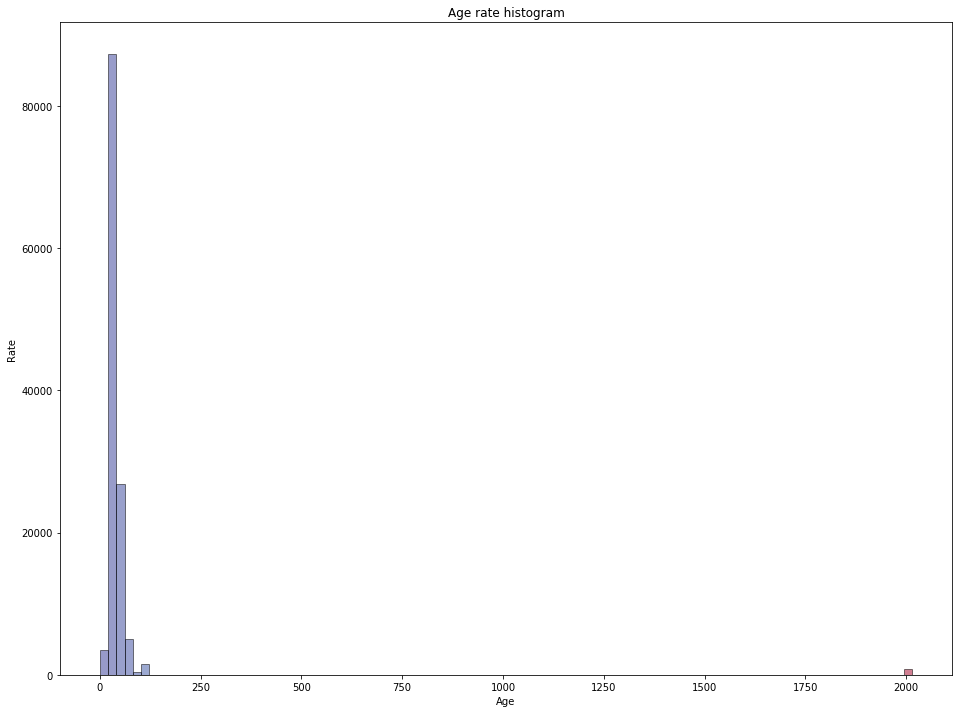

In [20]:
cm = plt.cm.get_cmap('RdYlBu_r')
fig = plt.figure(figsize=(16, 12))
ax = fig.add_subplot(111)
n, bins, patches = ax.hist(users_df['age'].dropna(), 100, color='green', alpha=0.5, histtype='bar', ec='black')
bin_centers = 0.5 * (bins[:-1] + bins[1:])

col = bin_centers - min(bin_centers)
col /= max(col)

for c, path in zip(col, patches):
    plt.setp(path, 'facecolor', cm(c))
ax.set_xlabel("Age")
ax.set_ylabel("Rate")
ax.set_title("Age rate histogram")
plt.show()

Construct a histogram for anomalous values exceeding 90.

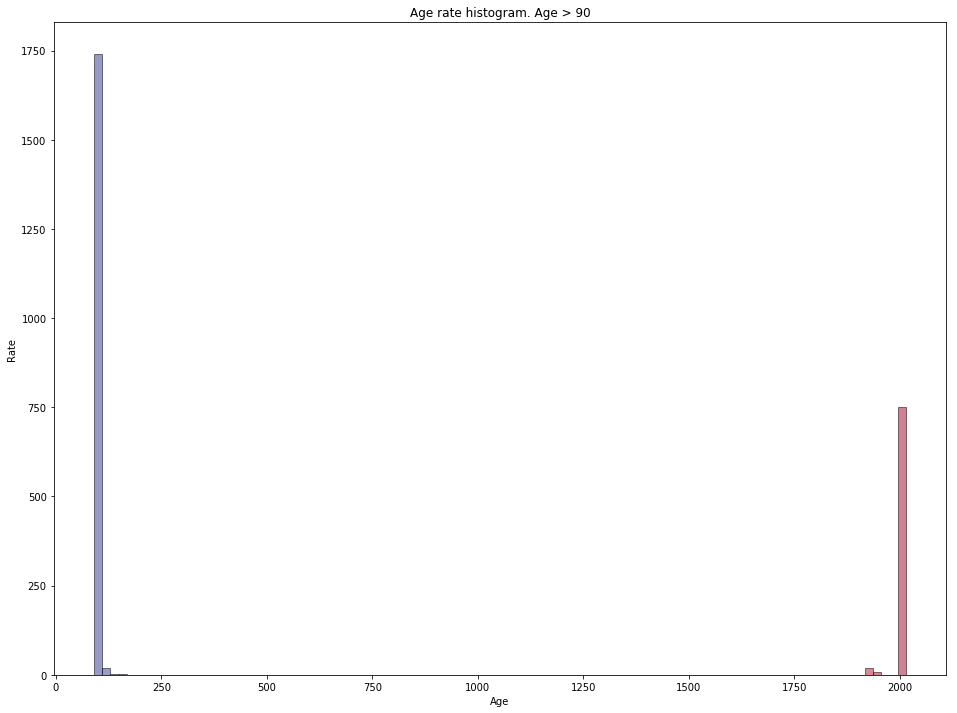

In [21]:
cm = plt.cm.get_cmap('RdYlBu_r')
fig = plt.figure(figsize=(16, 12))
ax = fig.add_subplot(111)
n, bins, patches = ax.hist(users_df.loc[users_df['age'] > 90, 'age'].dropna(), 100, color='green', alpha=0.5, histtype='bar', ec='black')
bin_centers = 0.5 * (bins[:-1] + bins[1:])

col = bin_centers - min(bin_centers)
col /= max(col)

for c, path in zip(col, patches):
    plt.setp(path, 'facecolor', cm(c))
ax.set_xlabel("Age")
ax.set_ylabel("Rate")
ax.set_title("Age rate histogram. Age > 90")
plt.show()

Construct a histogram for anomalous values smaller than 16.

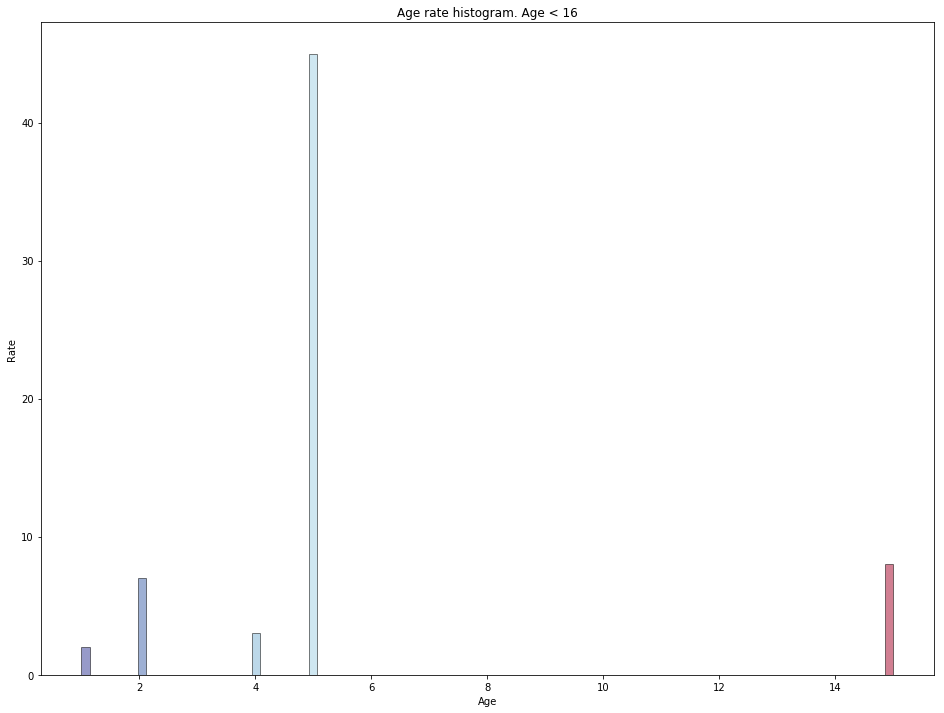

In [22]:
cm = plt.cm.get_cmap('RdYlBu_r')
fig = plt.figure(figsize=(16, 12))
ax = fig.add_subplot(111)
n, bins, patches = ax.hist(users_df.loc[users_df['age'] < 16, 'age'].dropna(), 100, color='green', alpha=0.5, histtype='bar', ec='black')
bin_centers = 0.5 * (bins[:-1] + bins[1:])

col = bin_centers - min(bin_centers)
col /= max(col)

for c, path in zip(col, patches):
    plt.setp(path, 'facecolor', cm(c))
ax.set_xlabel("Age")
ax.set_ylabel("Rate")
ax.set_title("Age rate histogram. Age < 16")
plt.show()

Suppose that all values of age less than 16 and greater than 90 are outliers and erroneus
(for example, the user made a mistake when entering and entered the current year, or only entered current month date that less then 16).
Assign to such dates NaN:

In [28]:
users_df.loc[users_df['age'] > 90, 'age'] = np.nan
users_df.loc[users_df['age'] < 16, 'age'] = np.nan

And fill them by age mode

In [44]:
#users_df.loc[users_df['age'].isna(), 'age'] = count_age_values.idxmax()
users_df.loc[users_df['age'].isna(), 'age'] = users_df['age'].mode()[0]

In [45]:
any(users_df['age'].isna())

False

Now we need to decide what to do with 'date_first_booking' column. Calculate what percentage of non NaN values:

In [ ]:
print("{}%".format(users_df[users_df['date_first_booking'].notna()].shape[0] / users_df.shape[0] * 100))

Since it contains only 42% not NaN values it seems appropriate to drop this column. Simple strategies - fill in the values with the most common value from the non NaN part, or the average is unlikely to fit here. Let's try a more complex approach.

Find the number of unique values in non NaN part of 'date_first_booking'.

In [46]:
len(users_df['date_first_booking'].unique())

1977

We see that the number of unique values is small compared to the number of rows in a dataset. Therefore, we can apply the frequency approach.  We can try to fill NaN values with values from the not NaN part with the same frequency (probabilities) distribution as in the not NaN part.  And further, when using for training the model, it will be possible to check both options - with the column droped and with the filled.

Apparently in the future we will use this approach of filling NaNs. Therefore, it makes sense to write a function for this.

In [ ]:
def fill_nans(df, column):
    #calculate number of NaNs in column
    na_len = len(df.loc[df[column].isna(), column])
    #create a pandas series containing values and corresponding quantities from not NaNs part of the column
    count_notna = df.loc[df[column].notna(), column].value_counts()
    #calculate relative frequencies (probabilities) of each value
    frequencies = count_notna / count_notna.sum()
    #make array that contain fill values with the same relative frequencies as in 'not NaN' column part
    fill_values = np.array(
        [np.random.choice(frequencies.index, p=frequencies.values) for _ in range(na_len)]
    )
    #fill NaNs
    df.loc[df[column].isna(), column] = fill_values
    return df

In [ ]:
users_df = fill_nans(users_df, 'date_first_booking')

In [ ]:
any(users_df['date_first_booking'].isna())

Now consider 'first_affiliate_tracked' column

In [ ]:
first_at_not_na_uniques_count = users_df.loc[
    users_df['first_affiliate_tracked'].notna(), 'first_affiliate_tracked'
].value_counts()

In [ ]:
first_at_not_na_uniques_count.shape

In [ ]:
first_at_not_na_uniques_count

In [ ]:
users_df[users_df['first_affiliate_tracked'].isna()].shape[0] / users_df.shape[0] * 100

We can see that 'first_affiliate_tracked' column contains 2.84% NaNs. And fill NaNs by mode value - 'untracked' it's not exactly what we need. Other values make up a large proportion of all values. Therefore, we do the same as with 'date_first_booking' column

In [ ]:
users_df = fill_nans(users_df, 'first_affiliate_tracked')

In [ ]:
any(users_df['first_affiliate_tracked'].isna())

In [ ]:
users_df.columns

Convert 'date_first_booking', 'date_account_created' and 'timestamp_first_active' to datetime, and add to users_df as new columns.

In [ ]:
#users_df_copy = users_df.copy()

In [ ]:
users_df['date_first_active'] = pd.to_datetime(users_df['timestamp_first_active'] // 1000000, format = '%Y%m%d')
users_df['date_first_booking_dt'] = pd.to_datetime(users_df['date_first_booking'])
users_df['date_account_created_dt'] = pd.to_datetime(users_df['date_account_created'])
#users_df_copy['date_first_active'] = pd.to_datetime(users_df_copy.timestamp_first_active // 1000000, format = '%Y%m%d')

In [ ]:
users_df.head()

Now consider the sessions dataset

In [ ]:
sessions_df.info()

In [ ]:
sessions_df.head()

In [ ]:
sessions_df.describe()

In [ ]:
sessions_df.isna().sum() / len(sessions_df) * 100

We can see that all columns, except 'device type', in sessions datasets have NaN values. 'action_type' and 'action_detail'
have about 11% NaNs. It seems appropriate to fill such values. And NaN in other columns should also be filled,
except 'user_id' column (NaNs in this column look at least strange.).
In this case, it is most advisable to delete rows containing NaN values in 'user_id' column, the more so because they
are few .
But first, let's take a closer look at this column.

In [ ]:
users_df_unique_user_ids = set(users_df['id'].unique())
sessions_df_unique_user_ids = set(sessions_df['user_id'].unique())

In [ ]:
print(len(users_df_unique_user_ids))
print(len(sessions_df_unique_user_ids))

We can see that the number of unique usrers identifiers is quite different.
Calculate numbers of match ids, and and not match ids.

In [ ]:
print("len of intersection:", len(users_df_unique_user_ids.intersection(sessions_df_unique_user_ids)))
print(
    "len of difference unique user ids in users_df and sessions_df:",
    len(users_df_unique_user_ids.difference(sessions_df_unique_user_ids)))
print("len of difference unique user ids in sessions_df and users_df:",
      len(sessions_df_unique_user_ids.difference(users_df_unique_user_ids)))

The most interesting is that in sessions dataset there are identifiers of which are not in users dataset. And number
of intersected users ids not very large. But, all the same, it makes sense to use user dataset in combination
with sessions dataset.

Preliminary results:
1. We can see that some columns in sessions data and users data have signficant numbers of NaN values.
sessions:
- user_id           0.326428% (which is curious in itself)
- action            0.753482%
action_type      10.657003%
action_detail    10.657003%
device_type       0.000000%
secs_elapsed      1.287229%

- 2. user_id column in sessions data contain 0.326428% NaNs, rows with will be deleted when we  will simultaneously use data from sessions and users datasets (or may be we find the way fill this values).
- 3. Deciding what to do with the NaNs in columns action_type and action_detail (Delete or fill by average, mode or by values that we can retrieve using simple ML models) requires additional exploring.
- 4. NaNs in secs_elapsed in session data we can fill by mean or mode.
- 5. NaNs in first_affiliate_tracked in users data make sense delete or fill by mode.
- 6. NaNs in date_first_booking requires additional exploring. Or delete whole column if additional exploring don't give result.
- 7. Same for age column.
- 8. It is also worth paying attention to the fact that the set of user IDs in sessions dataset and users dataset  do not match, but only intersect in some part of thes. There are users whose IDs are in session dataset  but not in users dataset, which strange.
- 9. It is also worthwhile to look in more detail at the distribution of the number of unique values in each column of each dataset.
- 10. Add columns with timestamps converted in datetime format.

Consider columns 'action', 'action_type', 'action_detail' in more detail.

In [ ]:
sessions_df['action'].value_counts()

Select rows with NaN in 'action' column

In [ ]:
action_nan = sessions_df[sessions_df['action'].isna()]

Calculate the number of unique values in 'action_type', 'action_detail', 'device_type' columns in those rows where there are NaNs in 'action' column

In [ ]:
print(len(action_nan['action_type'].unique()))
print(len(action_nan['action_detail'].unique()))
print(len(action_nan['device_type'].unique()))

In [ ]:
print(action_nan['action_type'].unique())
print(action_nan['action_detail'].unique())
print(action_nan['device_type'].unique())

We can see that 'action_type' and 'action_detail' contains the same value: 'message_post' if 'action'
contain NaN in that row

In [ ]:
action_not_na = sessions_df[sessions_df['action'].notna()]

In [ ]:
action_not_na_uniques = action_not_na['action'].unique()
action_type_not_na_uniques = action_not_na['action_type'].unique()
action_detail_not_na_uniques = action_not_na['action_detail'].unique()

In [ ]:
print('message_post' in action_type_not_na_uniques)
print('message_post' in action_detail_not_na_uniques)

We can see that  'action_type' and 'action_detail' contain 'message_post' also in rows where 'action' column not contain NaNs

Let's see what values are contained in columns 'action_type' and 'action_detail' in rows where there are no NaNs in 'action' column

In [ ]:
print(action_not_na.loc[action_not_na['action_type'] == 'message_post', 'action'].unique())
print(action_not_na.loc[action_not_na['action_detail'] == 'message_post', 'action'].unique())

We can see that values the same. Perhaps this will be useful during the in-depth study of this data. But here we will not do in-depth exploratory data analysis. 

Fill NaNs in 'action' column as we did earlier for 'date_first_booking' and 'first_affiliate_tracked' columns.

In [ ]:
sessions_df = fill_nans(sessions_df, 'action')

In [ ]:
any(sessions_df.loc[sessions_df['action'].isna(), 'action'])

Now consider columns 'action_type' and 'action_detail' itself. They have the same number of NaNs, and we can assume that the indices of the rows in which these values are located match up.

In [ ]:
all(sessions_df[sessions_df['action_type'].isna()].index == sessions_df[sessions_df['action_detail'].isna()].index)

The rows are the same as we expected. Now we select rows that contain NaN in 'action_type' and 'action_detail'
and rows that not contain. And we can use for selecting NaN and not NaN rows only one of them, 'action_type' for example

In [ ]:
act_td_nans_df = sessions_df[sessions_df['action_type'].isna()]
act_td_not_nans_df = sessions_df[sessions_df['action_type'].notna()]

In [ ]:
act_td_nans_df.shape

In [ ]:
act_td_nans_df.head()

In [ ]:
act_td_not_nans_df.shape

In [ ]:
act_td_not_nans_df.head()

In [ ]:
action_t_td_not_nans_uniques_count = act_td_not_nans_df['action_type'].value_counts()

In [ ]:
print(len(action_t_td_not_nans_uniques_count))

In [ ]:
action_d_td_not_nans_uniques_count = act_td_not_nans_df['action_detail'].value_counts()

In [ ]:
print(len(action_d_td_not_nans_uniques_count))

In [ ]:
print(action_t_td_not_nans_uniques_count.index)

In [ ]:
print(action_d_td_not_nans_uniques_count.index)

As we can see, the number of unique values in 'action_type' and 'action_detail' columns is small compared to the number of rows in these columns. Therefore, we can apply for filling NaNs in these columns the same frequency method as for 'action' column and 'date_first_booking' and 'first_affiliate_tracked' columns in users dataset.

In [ ]:
sessions_df = fill_nans(sessions_df, 'action_type')

In [ ]:
any(sessions_df.loc[sessions_df['action_type'].isna(), 'action_type'])

In [ ]:
sessions_df = fill_nans(sessions_df, 'action_detail')

In [ ]:
any(sessions_df.loc[sessions_df['action_detail'].isna(), 'action_detail'])

Fill NaNs in 'secs_elaplsed' by mean of not NaN part of 'secs_elapsed' (as it is continuos number variable this approach looks prefered)

In [ ]:
sessions_df.loc[sessions_df['secs_elapsed'].isna(), 'secs_elapsed'] = sessions_df['secs_elapsed'].mean()

Drop all rows where 'user_id' contain NaNs

In [ ]:
sessions_df =  sessions_df.drop(index=sessions_df[sessions_df['user_id'].isna()].index)

In [ ]:
any(sessions_df.loc[sessions_df['user_id'].isna(), 'user_id'])

We also convert the float values that contain 'secs_elapsed' column to timedelta and add a column with these values to the dataframe.

In [ ]:
sessions_df['secs_elapsed_timedelta'] = pd.to_timedelta(sessions_df['secs_elapsed'], unit='s')

On this dwell. We received a cosistant dataset that does not contain NaNs and outliers. The opposite approach is to remove all rows containing NaNs and columns containing a significant number of NaNs (for example, more than half). Thus, we also get consistent dataset.
Now we can (preferably after in-depth exploratory data analysis), use the resulting dataset to build various predictive models (using only users datasets or combining it in various ways with sessions datasets) using different algorithms (logistic regression, gradient boosting, SVM etc ..) It is further possible to combine the results of these models (using bagging or/and stacking, or more complex methods) to obtain more accurate predictions.